In [133]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [134]:
def process_company(company_data):
    try:
        m = company_data.money_raised_usd.values
        p = company_data.post_money_valuation_usd.values
        e = company_data.exit_value.values[0]

        if company_data.exit_type.values[0] == 3:
            ret = np.zeros_like(company_data.uuid) - 1
        elif company_data.shape[0] == 1:
            ret = [(m[0] / p[0] * e - m[0]) / m[0]]
        else:
            x0 = m / p # stake of investors at their first round
            x = (p[1:] - m[1:]) / p[1:] # dilution factors
            d = np.cumprod(x)[::-1]
            d = np.insert(d, len(d), 1)
            ret = (e * x0 * d - m) / m
        return pd.DataFrame(data=ret, index=company_data.uuid)
    except:
        print(company_data)
        return pd.DataFrame(data=[np.nan] * company_data.uuid.size, index=company_data.uuid)


def filter_dates(funding_round):
    return funding_round['announced_on'] < funding_round['exit_date']

In [135]:
rounds_data = pd.read_csv('obs_predicted_data.csv')

In [136]:
orgs = pd.read_csv("../../data/crunchbase/organizations.csv")
acqs = pd.read_csv("../../data/crunchbase/acquisitions.csv")
ipos = pd.read_csv("../../data/crunchbase/ipos.csv")

In [137]:
ipos = ipos[['org_uuid', 'went_public_on', 'valuation_price_usd']]
acqs = acqs[['acquiree_uuid', 'acquired_on', 'price_usd']]

In [138]:
rounds = rounds_data[['uuid', 'org_uuid', 'announced_on', 'money_raised_usd', 'post_money_valuation_usd']].copy()

ipos.columns = ['org_uuid', 'exit_date', 'exit_value']
acqs.columns = ['org_uuid', 'exit_date', 'exit_value']

clos = pd.DataFrame(orgs[['uuid', 'closed_on']].dropna())
clos.columns = ['org_uuid', 'exit_date']

ipos["exit_type"] = 1
acqs["exit_type"] = 2
clos["exit_type"] = 3
clos["exit_value"] = np.nan

exits = pd.concat([acqs, ipos, clos]).set_index("org_uuid")

In [139]:
rounds["exit_date"] = pd.to_datetime(rounds.org_uuid.map(exits["exit_date"].to_dict()))
rounds["exit_type"] = rounds.org_uuid.map(exits["exit_type"].to_dict()).fillna(value=4).astype(int)
rounds["exit_value"] = rounds.org_uuid.map(exits["exit_value"].to_dict())

In [140]:
ref_date = '1926-01-01'
rounds.announced_on = pd.Timestamp(ref_date) + rounds.announced_on * pd.Timedelta('1s')
rounds = rounds[(rounds.announced_on < rounds.exit_date)]
rounds = rounds.sort_values(by=['org_uuid', 'announced_on'])

In [141]:
rounds['return_usd'] = rounds.uuid.map(rounds.groupby('org_uuid').apply(process_company).droplevel(0)[0]) + 1

In [142]:
rounds = rounds.drop(columns=['uuid'])
rounds.insert(1, 'group_num', np.nan)
rounds.insert(2, 'seg_num', np.nan)

rounds.columns = ['company_num', 'group_num', 'seg_num', 'round_date', 'raised_usd',
                  'postvalue_usd', 'exit_date', 'exit_type', 'exit_value', 'return_usd']
rounds = rounds[rounds.round_date > '1990-01-01']

In [143]:
operating = rounds_data[['org_uuid', 'announced_on', 'money_raised_usd', 'post_money_valuation_usd']].copy()
operating = operating[~operating.org_uuid.isin(rounds.company_num)]

operating.announced_on = pd.Timestamp(ref_date) + operating.announced_on * pd.Timedelta('1s')
operating.insert(1, 'group_num', np.nan)
operating.insert(2, 'seg_num', np.nan)
operating.insert(operating.shape[1], 'exit_date', np.nan)
operating.insert(operating.shape[1], 'exit_type', 4)
operating.insert(operating.shape[1], 'exit_value', np.nan)
operating.insert(operating.shape[1], 'return_usd', np.nan)

operating.columns = ['company_num', 'group_num', 'seg_num', 'round_date', 'raised_usd',
                  'postvalue_usd', 'exit_date', 'exit_type', 'exit_value', 'return_usd']
operating = operating[operating.round_date.dt.year > 1990]

In [149]:
complete = pd.concat([rounds, operating], ignore_index=True)
complete.loc[complete.return_usd == 0, 'return_usd'] = np.nan
complete = complete[(complete.return_usd < 3000) | (complete.return_usd.isna())]
complete.exit_date = pd.to_datetime(complete.exit_date, errors="coerce")
complete.to_csv('../../data/data.csv', index=False)

In [150]:
complete

,company_num,group_num,seg_num,round_date,raised_usd,postvalue_usd,exit_date,exit_type,exit_value,return_usd
0,000cff2d-58df-0a9a-97ea-6b73ed9ec601,NaN,NaN,2016-07-21,100000.0,1.120240e+06,2020-03-06,2,NaN,NaN
1,0012f446-a31b-9eb8-4fa0-448ed0414112,NaN,NaN,2000-03-07,14000000.0,7.059858e+07,2005-06-01,3,NaN,NaN
2,00251aad-6e34-0898-8a72-fe8864a90f92,NaN,NaN,2012-10-04,650532.0,3.238880e+06,2016-11-08,2,NaN,NaN
3,002aac96-79d4-a8f3-8ef0-d44fb240951d,NaN,NaN,2000-05-12,3000000.0,1.126037e+07,2006-11-09,2,NaN,NaN
4,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,NaN,NaN,2016-01-11,45000000.0,2.104294e+08,2020-12-15,1,577580000.0,2.442438
...,...,...,...,...,...,...,...,...,...,...
119868,fffe3b0b-8545-4414-9c0e-a3f961c4e420,NaN,NaN,2017-02-07,14523274.0,8.525829e+07,NaT,4,NaN,NaN
119869,ffff2bea-7e44-4563-b311-65daadb683cd,NaN,NaN,2010-12-07,451407.0,2.387976e+06,NaT,4,NaN,NaN
119870,ffff2bea-7e44-4563-b311-65daadb683cd,NaN,NaN,2013-04-25,1616916.0,8.092737e+06,NaT,4,NaN,NaN
119871,ffffabce-6d4a-b3d1-13c0-4e90cedf5270,NaN,NaN,2016-05-15,210000.0,2.649445e+06,NaT,4,NaN,NaN


In [151]:
complete.exit_type.unique()

array([2, 3, 1, 4])

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
complete = pd.read_csv('../../data/data.csv')

/var/folders/9g/9p32rxp10c37hppq5lydn44c0000gn/T/ipykernel_5582/3889014812.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  complete = pd.read_csv('../../data/data.csv')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


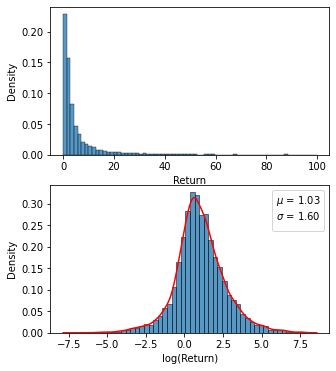

In [153]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,6))
sns.histplot(complete[complete.return_usd < 100].return_usd, ax=axs[0], bins=70, stat="density")
sns.histplot(np.log(complete.return_usd.dropna()), bins=50, stat="density", ax=axs[1])
sns.kdeplot(np.log(complete.return_usd.dropna()), color="r", ax=axs[1])
axs[0].set_xlabel('Return')
axs[1].set_xlabel('log(Return)')
axs[1].legend(title=f'$\mu$ = {np.log(complete.return_usd.dropna()).mean():.2f}\n$\sigma$ = {np.log(complete.return_usd.dropna()).std():.2f}')
plt.savefig('figures/returns.pdf')